# Story 3

*Do stricter gun laws reduce firearm gun deaths?*

In [122]:
import requests
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium


## Datasources

We can use the below NCHS API endpoint to see cause of death rates per state *per quarter* in the US. This will be a good starting point as we look to visualize per state

- [NCHS Leading Cause of Deathe API Endpoint](https://dev.socrata.com/foundry/data.cdc.gov/bi63-dtpu)

In [123]:
# Grabbing data from API endpoint
response = requests.get("https://data.cdc.gov/resource/489q-934x.json").json()

In [124]:
# Write response to pandas dataframe
df = pd.json_normalize(response)
df.head()

,year_and_quarter,time_period,cause_of_death,rate_type,unit,rate_overall,rate_sex_female,rate_sex_male,rate_alaska,rate_alabama,...,rate_age_1_4,rate_age_5_14,rate_age_15_24,rate_age_25_34,rate_age_35_44,rate_age_45_54,rate_age_55_64,rate_65_74,rate_age_75_84,rate_age_85_plus
0,2022 Q1,12 months ending with quarter,All causes,Age-adjusted,"Deaths per 100,000",873.2,729.4,1038,944.5,1109.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022 Q1,12 months ending with quarter,Alzheimer disease,Age-adjusted,"Deaths per 100,000",30.6,35,23.8,28.5,45.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022 Q1,12 months ending with quarter,COVID-19,Age-adjusted,"Deaths per 100,000",95,75.2,119.1,121.3,133.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022 Q1,12 months ending with quarter,Cancer,Age-adjusted,"Deaths per 100,000",145.9,127.4,170.9,156,159.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022 Q1,12 months ending with quarter,Chronic liver disease and cirrhosis,Age-adjusted,"Deaths per 100,000",14.4,10.3,18.9,25.5,16.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Wrangling

In [125]:
# Pulling out only firearm deaths that are age-adjusted
df = df.loc[(df.cause_of_death == "Firearm-related injury") & (df.rate_type == "Age-adjusted") & (df.time_period=="3-month period")]

In [126]:
# Select only needed columns and transpose our data
state_cols = ['year_and_quarter', 'rate_alaska', 'rate_alabama', 'rate_arkansas', 'rate_arizona',
              'rate_california', 'rate_colorado', 'rate_connecticut',
              'rate_district_of_columbia', 'rate_delaware', 'rate_florida',
              'rate_georgia', 'rate_hawaii', 'rate_iowa', 'rate_idaho',
              'rate_illinois', 'rate_indiana', 'rate_kansas', 'rate_kentucky',
              'rate_louisiana', 'rate_massachusetts', 'rate_maryland', 'rate_maine',
              'rate_michigan', 'rate_minnesota', 'rate_missouri', 'rate_mississippi',
              'rate_montana', 'rate_north_carolina', 'rate_north_dakota',
              'rate_nebraska', 'rate_new_hampshire', 'rate_new_jersey',
              'rate_new_mexico', 'rate_nevada', 'rate_new_york', 'rate_ohio',
              'rate_oklahoma', 'rate_oregon', 'rate_pennsylvania',
              'rate_rhode_island', 'rate_south_carolina', 'rate_south_dakota',
              'rate_tennessee', 'rate_texas', 'rate_utah', 'rate_virginia',
              'rate_vermont', 'rate_washington', 'rate_wisconsin',
              'rate_west_virginia', 'rate_wyoming', 'rate_overall']
df = df[state_cols].transpose()

# Set the first row (year_and_quarter) as column headers and remove it from the data
df.columns = df.iloc[0]
df = df.drop(df.index[0])

# Clean up state names and set index
df['state'] = [s.replace("_", " ").replace("rate", "").title().strip() for s in df.index]
df = df.set_index('state')

# Convert column data to float, skipping over missing data (NaN)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Display the cleaned DataFrame
df.head()

year_and_quarter,2022 Q1,2022 Q2,2022 Q3,2022 Q4,2023 Q1,2023 Q2,2023 Q3,2023 Q4,2024 Q1
state,,,,,,,,,
Alaska,22.8,20.2,24.4,22.3,18.7,24.4,23.3,27.6,NaN
Alabama,24.1,26.7,27.7,23.5,27.9,25.7,25.1,23.6,NaN
Arkansas,19.1,25.0,23.4,20.0,22.7,23.3,21.9,19.6,NaN
Arizona,18.6,22.6,20.7,18.6,18.0,18.3,18.9,18.8,NaN
California,8.3,8.9,9.4,7.9,8.1,7.7,8.4,7.4,NaN


## Data Visualization
Let's first plot the rate of firearm related homo

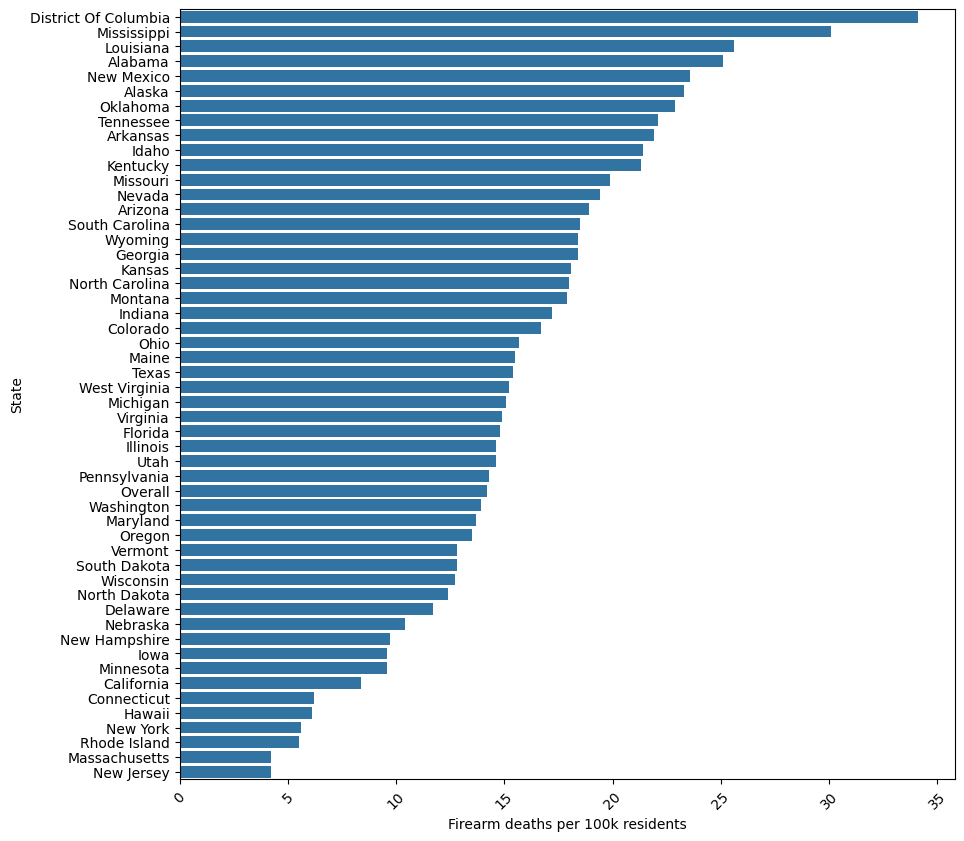

In [127]:
df_sorted = df.sort_values("2023 Q3", ascending=False)
order = df.groupby("state").sum().sort_values(['2023 Q3'], ascending=False).index

# Plot a sorted bar chart of deaths per 100k
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=df, x="2023 Q3", y="state", order=order, orient="h")
ax.set_xlabel("Firearm deaths per 100k residents")
ax.set_ylabel("State")
plt.xticks(rotation=45)

plt.show()

In [128]:
# Load the firearm mortality data from CSV
df_firearm_mortality = pd.read_csv('https://raw.githubusercontent.com/waheeb123/Datasets/refs/heads/main/data-table.csv')

# Check the structure of the data
df_firearm_mortality.head()


,YEAR,STATE,RATE,DEATHS,URL
0,2022,AL,25.5,"1,278",/nchs/pressroom/states/alabama/al.htm
1,2022,AK,22.4,164,/nchs/pressroom/states/alaska/ak.htm
2,2022,AZ,20.1,"1,535",/nchs/pressroom/states/arizona/az.htm
3,2022,AR,21.9,666,/nchs/pressroom/states/arkansas/ar.htm
4,2022,CA,8.6,"3,484",/nchs/pressroom/states/california/ca.htm
